# Levenshtein distance matrix computation for large datasets 
Data & AI course, UC Leuven, 2021 Fall

### Project supervisors
- Tom Magerman
- Aimée Lynn Backiel

### Project team (Group 4)
- Karolis Medekša
- Pedro Teixeira Palma Rosa
- Hysa Mello de Alcântara
- Josep Jacob Chetrit Valdepeñas

## Goals
The goal of the assignment is to implement a solution for generating an edit distance (Levenshtein distance) matrix for large datasets of strings. We can derive three subtasks from the assignment:
- Investigate different options for calculating Levenshtein distance
- Benchmark and pick an optimal solution suitable for large inputs

# Preparing input and validation data
In the final solution the tool will be used to calculate edit distances among many different street adresses. However, for calculating Levenshtein distance it is not important what type of data we are using as long as they are valid string. Therefore, we can prepare test data in advance:
- A text file containing a fixed number of random strings.
- A text file containing a pre-computed distance matrix of the strings.
A pre-computed distance matrix will allow for quick verification if a custom matrix calcualtion strategy works.
For computatation an external library [python-Levenshtein](https://pypi.org/project/python-Levenshtein/) will be used as it is known to work correctly.

In [1]:
import string
import random
import numpy as np
from Levenshtein import distance

TEST_DATA_SIZE = 10
DEFAULT_MIN_STR_LENGTH = 5
DEFAULT_MAX_STR_LENGTH = 60
DEFAULT_CHARS_TO_CHOOSE = string.ascii_uppercase + string.digits + string.punctuation + ' '

def get_random_string(size=None, chars=DEFAULT_CHARS_TO_CHOOSE):
    sz = size if size else random.randint(DEFAULT_MIN_STR_LENGTH, DEFAULT_MAX_STR_LENGTH)
    return ''.join(random.choice(chars) for _ in range(sz))

In [2]:
TEXT_SAMPLE_FILENAME = '../validation-data/sample.txt'
DISTANCES_SAMPLE_FILENAME = '../validation-data/distances.csv'

def generatePair():
    print('\nSeeding initiated for {} records'.format(TEST_DATA_SIZE))
    random_strings: np.array = np.array([get_random_string() for _ in range(TEST_DATA_SIZE)])
    np.savetxt(TEXT_SAMPLE_FILENAME, random_strings, fmt='%s')
    
    print('Entries generated, seeding the distance matrix...')
    distance_matrix = np.fromfunction(
        np.vectorize(lambda i, j: distance(random_strings[i], random_strings[j])), 
        (TEST_DATA_SIZE, TEST_DATA_SIZE), 
        dtype=int
    )
    np.savetxt(DISTANCES_SAMPLE_FILENAME, distance_matrix, fmt='%d', delimiter=';')

    print('Success!')

In [3]:
generatePair()


Seeding initiated for 10 records
Entries generated, seeding the distance matrix...
Success!


Now we have both a text file containing random strings and the pre-computed distance matrix:

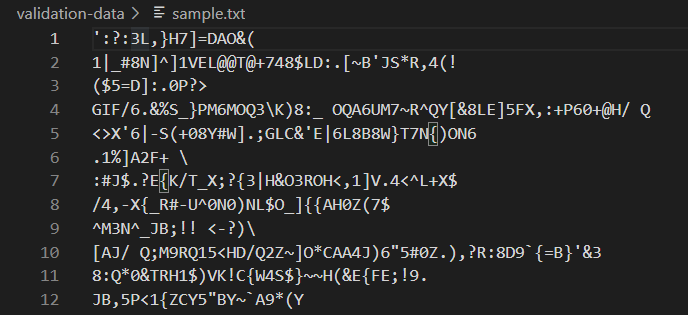
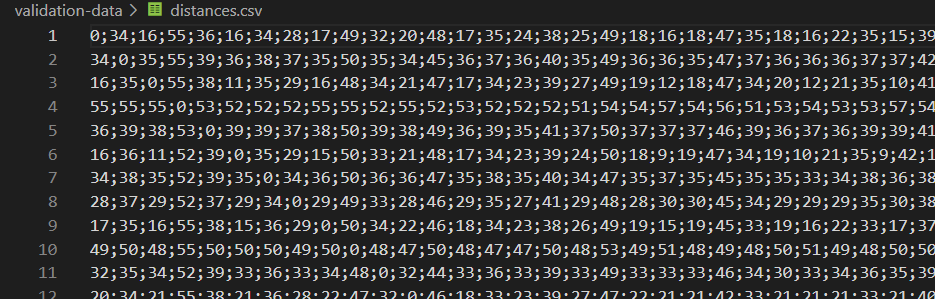

# Using python-Levenshtein library
To measure performance of a solution it is necessary to create utility functions for measuring elapsed time:

In [5]:
def log_alg_start(alg_name: str):
    print('Starting the calculation of the matrix using {}'.format(alg_name))


def log_alg_time(duration: float):
    print('Execution finished in {:.6f}s'.format(duration))

Now it is possible to define a function that accepts a `numpy` array and returns the distance matrix by using the library used during test data generation:

In [6]:
import time

def use_levenshtein_library(input_array) -> np.array:
    array_size = len(input_array)

    log_alg_start('python-levenshtein library methods')

    start = time.perf_counter()
    matrix = np.fromfunction(
        np.vectorize(lambda i, j: distance(input_array[i], input_array[j])), 
        (array_size, array_size), 
        dtype=int
    )

    log_alg_time(time.perf_counter() - start)

    return matrix

Reading input data from a generated file:

In [7]:
import pandas as pd
import csv

def read_input_arr() -> np.array:
    return pd.read_csv(
        TEXT_SAMPLE_FILENAME, 
        delimiter='\n', 
        quoting=csv.QUOTE_NONE, 
        comment=None, 
        header=None, 
        dtype=str
    )[0].to_numpy()

input_array = read_input_arr()

Using the algorithm:

In [12]:
result_matrix = use_levenshtein_library(input_array)

Starting the calculation of the matrix using python-levenshtein library methods
Execution finished in 2.310298s


We can also verify that the matrix was created correctly:

In [8]:
def verify_matrix_correctness(input_array, computed_matrix: np.array):
    """
    Verifies that computed distance matrix is correct by comparing it to pre-computed lavenshtein distance results

    Parameters
    ----------
    input_array: an array of string values.
    computed_matrix: distance matrix that needs to be verified
    """

    target_matrix = np.genfromtxt(DISTANCES_SAMPLE_FILENAME, delimiter=";")
    diffs: np.array = np.argwhere(computed_matrix != target_matrix)

    if len(diffs):
        print('Found incorrectly calculated distances:')

        diffs_to_ignore = set()
        for diff in diffs:
            if (diff[1], diff[0]) in diffs_to_ignore:
                continue
            print('Levenshtein distance between {} and {} was {}, should be {}'.format(
                input_array[diff[0]], 
                input_array[diff[1]], 
                computed_matrix[diff[0], diff[1]], 
                target_matrix[diff[0], diff[1]]
            ))
            diffs_to_ignore.add((diff[1], diff[0]))
        
        print('{} errors in total'.format(len(diffs_to_ignore)))
    else:
        print('Distance validation succeeded!')

In [16]:
verify_matrix_correctness(input_array, result_matrix)

Distance validation succeeded!


# Using polyleven library
After some research a less-popular edit distance calculation library was discovered. It is special, because it allows specifying a maximum edit distance, than can allow saving on computation time for long unmatching strings.

In [15]:
from polyleven import levenshtein

levenshtein('I like Paris', 'I like to party')

6

In [16]:
levenshtein('I like Paris', 'I like to party', 2)

3

In [60]:
def use_polyleven_library(input_array) -> np.array:
    array_size = len(input_array)

    log_alg_start('polyleven library methods')

    start = time.perf_counter()
    matrix = np.fromfunction(
        np.vectorize(lambda i, j: levenshtein(input_array[i], input_array[j])),
        (array_size, array_size), 
        dtype=int
    )

    log_alg_time(time.perf_counter() - start)

    return matrix

In [61]:
result_matrix = use_polyleven_library(input_array)
verify_matrix_correctness(input_array, result_matrix)

Starting the calculation of the matrix using polyleven library methods
Execution finished in 0.711120s
Distance validation succeeded!


We can notice that the library offers significantly shorter computation time, it's even lover if we specify a low difference boundary:

In [53]:
def use_polyleven_library(input_array) -> np.array:
    array_size = len(input_array)

    log_alg_start('polyleven library methods')

    start = time.perf_counter()
    matrix = np.fromfunction(
        np.vectorize(lambda i, j: levenshtein(input_array[i], input_array[j], 5)),
        (array_size, array_size), 
        dtype=int
    )

    log_alg_time(time.perf_counter() - start)

    return matrix

result_matrix = use_polyleven_library(input_array)
print(result_matrix[0:3, 0:3])

Starting the calculation of the matrix using polyleven library methods
Execution finished in 0.440341s
[[0 6 6]
 [6 0 6]
 [6 6 0]]


# Using a python distance function implementation
We can try writing a function for calculating the distance by our own. A simple dynamic programming implementation in python:

In [17]:
def levenshtein_distance_DP(token1, token2):
    distances = np.zeros((len(token1) + 1, len(token2) + 1), dtype=np.int32)

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
            
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                distances[t1][t2] = 1 + min(
                    distances[t1][t2 - 1],
                    distances[t1 - 1][t2],
                    distances[t1 - 1][t2 - 1]
                )

    return distances[len(token1)][len(token2)]

In [18]:
def use_custom_dp_algorithm(input_array) -> np.array:
    array_size = len(input_array)

    log_alg_start('a python DP algorithm')

    start = time.perf_counter()
    matrix = np.fromfunction(
        np.vectorize(lambda i, j: levenshtein_distance_DP(input_array[i], input_array[j])), 
        (array_size, array_size), 
        dtype=int
    )

    log_alg_time(time.perf_counter() - start)

    return matrix

Let's generate smaller amount of test data, as it can be expected that the Python implementation will be slower

In [21]:
TEST_DATA_SIZE = 100
generatePair()
input_array = read_input_arr()


Seeding initiated for 100 records
Entries generated, seeding the distance matrix...
Success!


In [22]:
result_matrix = use_custom_dp_algorithm(input_array)

Starting the calculation of the matrix using a dp algorithm optimised
Execution finished in 12.960262s


In [24]:
verify_matrix_correctness(input_array, result_matrix)

Distance validation succeeded!


We can conclude, that the python implementation is overwhelmingly slower than an external library written in `C`. Even with a smaller dataset the execution time is significantly longer.

# Using a "jitted" python implementation
The main reason why `python` code is so slow, is because it is being interpreted, rather than compiled, like `C`. We man make use of `numba` library to create a `jitted` function, that is compiler before being executed.


First we use a decorator to wrap the original function and call it one time so that the function is compiled.

In [19]:
from numba import jit

optimizedDp = jit(levenshtein_distance_DP)
# First call compiles the function before executing
_ = optimizedDp('A', 'B')

In [20]:
def use_custom_dp_algorithm_optimized(input_array) -> np.array:
    array_size = len(input_array)

    log_alg_start('a dp algorithm optimised with numba.jit')

    start = time.perf_counter()
    matrix = np.fromfunction(
        np.vectorize(lambda i, j: optimizedDp(input_array[i], input_array[j])), 
        (array_size, array_size), 
        dtype=int
    )

    log_alg_time(time.perf_counter() - start)

    return matrix

In [30]:
result_matrix = use_custom_dp_algorithm_optimized(input_array)
verify_matrix_correctness(input_array, result_matrix)

Starting the calculation of the matrix using a dp algorithm optimised with numba.jit
Execution finished in 2.057420s
Distance validation succeeded!


Simply by using `numba.jit` we can cut down the execution time by 6 times! However, even the "jitted" implementation is overwhelmingly slower than the external library, as the test was executed with a 10 times smaller input data size.

# Parallelizing the inner loop with GPU
GPU paralellization implementation was based on the following academic articles:
 - https://www.researchgate.net/publication/300042590_Using_GPUs_to_Speed-Up_Levenshtein_Edit_Distance_Computation
 - https://www.semanticscholar.org/paper/Accelerating-Levenshtein-and-Damerau-edit-distance-Balhaf-Alsmirat/88eab0140c32bdb9adf6ccba239f844840981e60

The problem with parallelizing Levenshtein distance computation (the inner loop) is that a matrix needs to computed, and the values of the matrix are dependant on one another:
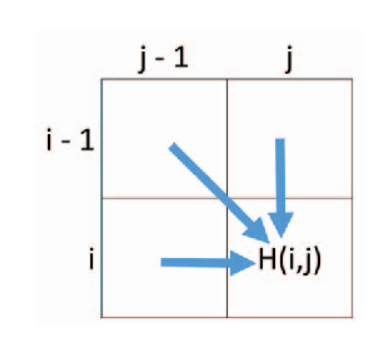 As a result, it is not possible to calculate all the values in parallel.

A solution could be to calculate one diagonal at a time. Because calculation a value in a current diagonal only depends on the previous diagonal, each cell in one diagonal can be computed in parallel:

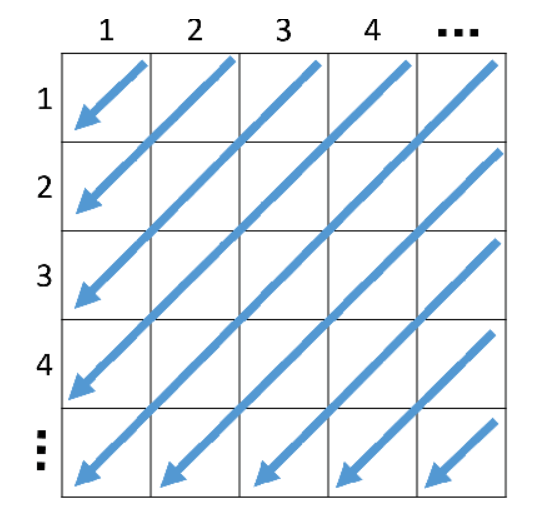

## CPU bound diagonal implementation
A simple, single-threaded algorithm for calculating Levenshtein distance using diagonal pattern is displayed below. `numba.njit` is used to optimize the function:

In [21]:
from numba import njit

@njit
def diagonal(token1, token2):
    width = len(token1) + 1
    height = len(token2) + 1

    distances = np.zeros((width, height))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2

    for slice in range(0, width + height - 1):
        zy = 0 if slice < height else slice - height + 1
        zx = 0 if slice < width else slice - width + 1

        for row in range(zy, slice - zx + 1):
            col = slice - row
            if row == 0 or col == 0: continue

            score = 0 if token1[row - 1] == token2[col - 1] else 1
            distances[row][col] = min(
                distances[row - 1][col - 1] + score,
                distances[row][col - 1] + 1,
                distances[row - 1][col] + 1
            )
    return distances[-1][-1]

_ = diagonal('a', 'b')

In [22]:
def use_diagonal_dp_algorithm_base(input_array) -> np.array:
    array_size = len(input_array)

    log_alg_start('a diagonal algorithm optimised with njit')

    matrix = np.zeros((array_size, array_size))
    start = time.perf_counter()

    matrix = np.fromfunction(
        np.vectorize(lambda i, j: diagonal(input_array[i], input_array[j])), 
        (array_size, array_size), 
        dtype=int
    )
    log_alg_time(time.perf_counter() - start)

    return matrix

In [36]:
result_matrix = use_diagonal_dp_algorithm_base(input_array)
verify_matrix_correctness(input_array, result_matrix)

Starting the calculation of the matrix using a diagonal algorithm optimised with njit
Execution finished in 2.126188s
Distance validation succeeded!


There is no performance gain compared to a regular `DP` implementation. Now let's try plugging a GPU into the equation. `levenshtein_kernel` is the function that runs on the GPU, it computes the distance of a single cell in a diagonal:

# Parallelized diagonal computation with Cuda

In [23]:
from numba import cuda

@cuda.jit('void(int32[:], int32[:], int32[:,:], int16, int16, int32)')
def levenshtein_kernel(token1, token2, distances, zy, slice, thread_count):
    thread_index = cuda.grid(1)
    if(thread_index >= thread_count): return

    row = zy + thread_index
    col = slice - row
    if row == 0 or col == 0: return

    score = 0 if token1[row - 1] == token2[col - 1] else 1
    distances[row][col] = min(
        distances[row - 1][col - 1] + score,
        distances[row][col - 1] + 1,
        distances[row - 1][col] + 1
    )

`numba` device functions do not work with `string` arrays, therefore, each string needs to be converted into a numerical array, where each integer represents a character. `levenshtein_root` is the function that schedules GPU jobs for each diagonal:

In [24]:
@jit('int16(unicode_type, unicode_type)', forceobj = True)
def levenshtein_root(token1: str, token2: str):
    width = len(token1) + 1
    height = len(token2) + 1

    numeric_token_1 = cuda.to_device(np.array([ord(x) for x in token1], dtype=np.int32))
    numeric_token_2 = cuda.to_device(np.array([ord(x) for x in token2], dtype=np.int32))

    distances = np.zeros((width, height), dtype=np.int32)
    
    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2

    d_distances = cuda.to_device(distances)

    for slice in range(0, width + height - 1):
        zy = 0 if slice < height else slice - height + 1
        zx = 0 if slice < width else slice - width + 1

        sliceCount = slice - zx + 1 - zy
        numBlocks = int((sliceCount + 256 - 1) / 256)
        levenshtein_kernel[numBlocks, 256](numeric_token_1, numeric_token_2, d_distances, zy, slice, sliceCount)

    return d_distances[-1][-1]

_ = levenshtein_root('a', 'b')

In [41]:
def use_diagonal_cuda_algorithm(input_array) -> np.array:
    array_size = len(input_array)

    log_alg_start('a diagonal agorithm with cuda')

    matrix = np.zeros((array_size, array_size))

    start = time.perf_counter()

    matrix = np.fromfunction(
        np.vectorize(lambda i, j: levenshtein_root(input_array[i], input_array[j])), 
        (array_size, array_size), 
        dtype=int
    )

    log_alg_time(time.perf_counter() - start)

    return matrix

In [42]:
result_matrix = use_diagonal_cuda_algorithm(input_array)
verify_matrix_correctness(input_array, result_matrix)

Starting the calculation of the matrix using a diagonal agorithm with cuda
Execution finished in 78.108257s
Distance validation succeeded!


Although we can verify that the algorithm works and produces correct results, the execution time is overwhelmingly long. In the papers mentioned earlier, a huge increase in performance can be observed with very long strings:
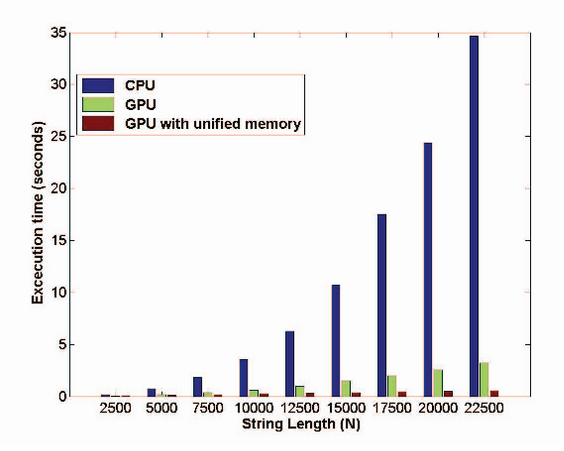

With values which are comparatively short (under thousand characters) in length, diagonal cuda implementation is not effective, as data copying and scheduling of jobs takes more time than the actual computations.

# Native Python multiprocessing

## Processes and Pipes

Divides the code in as many processes as processors and uses a shared memory between processes, called pipe. After that merge all the matrices in one. Takes too long


In [ ]:
from multiprocessing import Process, cpu_count, Pipe
import time

def dist(a, b):
    return distance(a,b)

    
def calculatePartialMatrix(input_array, x, send_end):
    matrix = np.fromfunction(
        np.vectorize(lambda i, j: dist(x[i], input_array[j])), 
        (len(x), len(input_array)), 
        dtype=int
    )
    send_end.send(matrix)
   
   
def use_levenshtein_library_parallel(complete_array) -> np.array: 
    array_size = len(complete_array)
    ncpus = cpu_count()
    equal_pieces = np.array_split(complete_array, ncpus)
    
    procesess = []
    pipe_list = []
    
    log_alg_start('python-levenshtein library methods')
    start = time.perf_counter()
    
    for x in range(ncpus):
        recv_end, send_end = Pipe(False)
        process = Process(target=calculatePartialMatrix, args=(complete_array, equal_pieces[x], send_end,))
        procesess.append(process)
        pipe_list.append(recv_end)
        process.start()
        
    for p in procesess:
        p.join()
        
    result = [x.recv() for x in pipe_list]
    final = np.empty([0,array_size], int)
    for r in result:
        final = np.append(final, r, axis= 0)

    log_alg_time(time.perf_counter() - start)

    return final

result_matrix = use_levenshtein_library_parallel(input_array)
verify_matrix_correctness(input_array, result_matrix)

Starting the calculation of the matrix using python-levenshtein library methods


## Pool
Pool is a class from multiprocessing, that was suposed to paralelize the creation of the distance matrix, that turned out beeing slower than the sequential code.

In [ ]:
from multiprocessing import cpu_count, Pool
import time

def calculatePartialMatrix(tuples):
    list1 = tuples[0].tolist()
    list2 = tuples[1].tolist()
    matrix = np.fromfunction(
        np.vectorize(lambda i, j: dist(list2[i], list1[j])), 
        (len(list2), len(list1)), 
        dtype=int
    )
    return matrix

def use_levenshtein_library_parallel(complete_array) -> np.array:
    ncpus = cpu_count()
    
    #divides the array in equal pieces, as much as the computer processors
    equal_pieces = np.array_split(complete_array, ncpus)
    log_alg_start('python-levenshtein library methods')
    start = time.perf_counter()
    
    #creates an array for the pool function to iterate
    data = np.array([[complete_array, equal_pieces[0]], [complete_array, equal_pieces[1]], 
                         [complete_array, equal_pieces[2]], [complete_array, equal_pieces[3]],
                         [complete_array, equal_pieces[4]], [complete_array, equal_pieces[5]], 
                         [complete_array, equal_pieces[6]], [complete_array, equal_pieces[7]],])

    result_objs = []

    with Pool(6) as p:
        result = np.array(p.map(calculatePartialMatrix, data))
        result_objs.append(result)

    final = np.empty([0,array_size], int)
    for r in result_objs:
            for j in r:
                final = np.append(final, j, axis= 0)

    log_alg_time(time.perf_counter() - start)
    
    return final

result_matrix = use_levenshtein_library_parallel(input_array)
verify_matrix_correctness(input_array, result_matrix)

As we can see, takes so much time to run and for some reason it does no do things in parallel, using only one processor, so it's an implementation that we did not continued.

## Dask array
Dask Array implements a subset of the NumPy ndarray interface using blocked algorithms, cutting up the large array into many small arrays. This lets us compute on arrays larger than memory using all cores. We also tried using this type of arrays to see if it would speed up the calculation.

### Frompyfunc
Used to take an arbitrary Python function and returns a NumPy ufunc. Combined with the outer() function what it does is that, for each row runs the function with all the columns. This runs sequentially and was a first test with Dask array functions

In [ ]:
import dask.array as da
import dask
import time

def use_levenshtein_library_parallel_dask(input_array) -> np.array:
    log_alg_start('parallel implementation with dask')

    start = time.perf_counter()
    
    matrix = da.frompyfunc(levenshtein, 2, 1).outer(input_array, input_array) 
    
    log_alg_time(time.perf_counter() - start)

    return matrix

result_matrix = use_levenshtein_library_parallel_dask(input_array)
verify_matrix_correctness(input_array, result_matrix)

### Delayed
Delayed is a function from Dask that stacks all proceses and paralelize them.

In [ ]:
import dask.array as da
import dask
import dask.bag as db
import time

def dist(a,b):
    c = da.frompyfunc(distance, 2, 1).outer(a, b)
    return c

def use_levenshtein_library_delayed_dask(input_array) -> np.array:
    log_alg_start('python-levenshtein with dask library methods')

    start = time.perf_counter()
    
    array_size = len(input_array)
    ncpus = cpu_count()
    equal_pieces = db.from_sequence(input_array, npartitions=ncpus)
    
    pieces_matrix = []
    for piece in equal_pieces:
        result = dask.delayed(dist)(input_array, piece)
        pieces_matrix.append(result)    
       
    final = np.empty([0,array_size], int)
    
    total = dask.delayed(np.append)(final, pieces_matrix, axis=0)
    matrix = total.compute()
    
    log_alg_time(time.perf_counter() - start)
    
    return matrix

result_matrix = use_levenshtein_library_delayed_dask(input_array)
verify_matrix_correctness(input_array, result_matrix)

This implementation took more than the triple of the normal one.

### Blockwise
The blockwise function applies an in-memory function across multiple blocks of multiple inputs in a variety of ways.

In [ ]:
import dask.array as da
import dask
import dask.bag as db
import time

def use_levenshtein_library_blockwise_dask(input_array) -> np.array:
    log_alg_start('parallel implementation with dask')

    start = time.perf_counter()
    
    distance = da.frompyfunc(levenshtein, 2, 1)
    
    w = da.from_array(input_array, chunks=(100))
    z = da.blockwise(distance.outer, 'ij', w, 'i', w, 'j', dtype='f8')
    matrix = z.compute(scheduler='processes')
    
    log_alg_time(time.perf_counter() - start)

    return matrix

result_matrix = use_levenshtein_library_blockwise_dask(input_array)
verify_matrix_correctness(input_array, result_matrix)

This one was a really good one, but turned out that it only uses 20% of each processor.

### Mapblocks
Map a function across all blocks of a dask array. It doesn't run as fast as we thoght it would.

In [ ]:
import dask.array as da
import dask
import dask.bag as db
import time

def use_levenshtein_library_mapblocks_dask(input_array) -> np.array:
    log_alg_start('parallel implementation with dask')

    start = time.perf_counter()
    
    distance = da.frompyfunc(levenshtein, 2, 1)
    
    size = input_array.size
    a = da.from_array(input_array, chunks=(size))
    b = a.map_blocks(lambda x: distance(x[:, None], x), dtype=str, chunks=((size,size),))
    matrix = b.compute()
    
    log_alg_time(time.perf_counter() - start)

    return matrix

result_matrix = use_levenshtein_library_mapblocks_dask(input_array)
verify_matrix_correctness(input_array, result_matrix)

# Python multiprocessing libraries


For further testing purposes we generate a larger dataset with 10 thousand records. 

In [76]:
TEST_DATA_SIZE = 10000
generatePair()
input_array = read_input_arr()


Seeding initiated for 10000 records
Entries generated, seeding the distance matrix...
Success!


A baseline model using a single-threaded realisation:

In [66]:
def use_polyleven_library(input_array) -> np.array:
    array_size = len(input_array)

    log_alg_start('polyleven library methods')

    start = time.perf_counter()
    matrix = np.fromfunction(
        np.vectorize(lambda i, j: levenshtein(input_array[i], input_array[j])),
        (array_size, array_size), 
        dtype=int
    )

    log_alg_time(time.perf_counter() - start)

    return matrix

result_matrix = use_polyleven_library(input_array)
verify_matrix_correctness(input_array, result_matrix)

Starting the calculation of the matrix using polyleven library methods
Execution finished in 60.898396s
Distance validation succeeded!


## MPIRE (MultiProcessing Is Really Easy)
[MPIRE](https://github.com/Slimmer-AI/mpire) library has an interface similar to a default library, but boasts of both faster computation and easier usage. In the following test, we launch as many parallel jobs to process data as there are cpus on the system

In [25]:
from multiprocessing import cpu_count
from mpire import WorkerPool

def compute_partial_matrix(x, complete_array):
    return np.fromfunction(
        np.vectorize(lambda i, j: levenshtein(x[i], complete_array[j])), 
        (len(x), len(complete_array)), 
        dtype=int
    )

def use_mpire(complete_array) -> np.array:     
    ncpus = cpu_count()
    equal_pieces = np.array_split(complete_array, ncpus)

    log_alg_start('polyleven library with mpire parallelization')
    start = time.perf_counter()

    with WorkerPool(n_jobs=ncpus) as pool:
        final = np.concatenate(
            pool.map(compute_partial_matrix, ((equal_pieces[x], complete_array) for x in range(ncpus)), iterable_len=ncpus),
            axis=0
        )

    log_alg_time(time.perf_counter() - start)
    
    return final

MPIRE's multiprocessing does not work in the notebook, here are the results of the test when ran from the console:
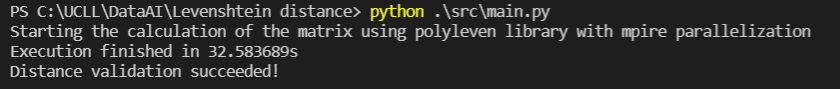
We get a 2x increase in processing time with MPIRE!

## Ray
[Ray](https://www.ray.io/) is a popular computation scalability library for python. Although `Windows` support is still in the works, a package can still be installed and used with `pip install`.

In [26]:
import ray

def use_ray(complete_array) -> np.array:     
    ncpus = cpu_count()
    equal_pieces = np.array_split(complete_array, ncpus)

    print('Initializing ray')
    start = time.perf_counter()

    ray.init(num_cpus=ncpus)
    remote_function = ray.remote(compute_partial_matrix)
    print('Took {:.6f}s'.format(time.perf_counter() - start))

    log_alg_start('polyleven library with ray parallelization')
    start = time.perf_counter()

    final = np.concatenate(
        ray.get([remote_function.remote(equal_pieces[x], complete_array) for x in range(ncpus)]),
        axis=0
    )
        
    log_alg_time(time.perf_counter() - start)
    return final

In [100]:
ray.shutdown()
result_matrix = use_ray(input_array)
verify_matrix_correctness(input_array, result_matrix)

Initializing ray
Took 12.369695s
Starting the calculation of the matrix using polyleven library with ray parallelization
Execution finished in 14.482323s
Distance validation succeeded!


We can observe a 2x speedup in processing compared to MPIRE and 4x increase compared to a single threaded realisation. On the other hand, initialization of ray takes a very large amount of time, therefore, with 10k records it's not, in general, faster than MPIRE. 

## joblib
[joblib](https://joblib.readthedocs.io/en/latest/) is a simple to use, but powerful job paralellization library.

In [27]:
from joblib import Parallel, delayed

def use_joblib(complete_array) -> np.array:     
    ncpus = cpu_count()
    equal_pieces = np.array_split(complete_array, ncpus)

    log_alg_start('polyleven library with joblib parallelization')
    start = time.perf_counter()
    final = np.concatenate(
        Parallel(n_jobs=ncpus)(delayed(compute_partial_matrix)(equal_pieces[x], complete_array) for x in range(ncpus)), 
        axis=0
    )
    log_alg_time(time.perf_counter() - start)
    
    return final

In [104]:
result_matrix = use_joblib(input_array)
verify_matrix_correctness(input_array, result_matrix)

Starting the calculation of the matrix using polyleven library with joblib parallelization
Execution finished in 13.708533s
Distance validation succeeded!


joblib shows a slightly better performance than ray, therefore, it will be used for the final solution.

# Handling large amount of data
If we try and run the solution with an extremely large dataset, for instance, with 1mil records, the script will run out of memory:

In [28]:
def generateInputOnly():
    print('\nSeeding initiated for {} records'.format(TEST_DATA_SIZE))
    random_strings: np.array = np.array([get_random_string() for _ in range(TEST_DATA_SIZE)])
    np.savetxt(TEXT_SAMPLE_FILENAME, random_strings, fmt='%s')
    
    print('Success!')

In [107]:
TEST_DATA_SIZE = 1000000
generateInputOnly()
input_array = read_input_arr()


Seeding initiated for 1000000 records
Success!


In [108]:
result_matrix = use_joblib(input_array)

Starting the calculation of the matrix using polyleven library with joblib parallelization


MemoryError: Unable to allocate 621. GiB for an array with shape (2, 83334, 1000000) and data type int32

One way around this problem is not to store the whole 1\*10^12 size matrix in memory and apply a concept of a sparse matrix. As we are only interested in strings that are similar, we can choose a boundary for the highest edit distance to compute. [sparse](https://sparse.pydata.org/en/stable/) library supports sparse matrices with custom `fill_value` criteria, so we can use it to save space for largely differing strings:

In [44]:
import sparse

def compute_partial_matrix(x, complete_array):
    return sparse.COO.from_numpy(np.fromfunction(
        np.vectorize(lambda i, j: levenshtein(x[i], complete_array[j], 4)), 
        (len(x), len(complete_array)), 
        dtype=int
    ), fill_value=5)

If we try processing all data at once, it is also likely that we'll run out of memory. Therefore, it makes sense to process data in chunks. `DESIRED_CHUNK_SIZE` holds how many integers should be inside one chunk. With `12` workers, 100k entries and chunk size of 1\*10^7 the process uses ~8GB of RAM.

In [45]:
DESIRED_CHUNK_SIZE = 1 * 1e7

In [46]:
def use_joblib_sparse(complete_array) -> sparse.COO:
    chunk_count = max(1, int((len(complete_array)**2)/DESIRED_CHUNK_SIZE))
    worker_count = min(cpu_count(), chunk_count)    
    
    equal_pieces = np.array_split(complete_array, chunk_count)

    log_alg_start('polyleven library with joblib parallelization and sparse matrices')
    print('Using {} worker(s) and {} chunks'.format(worker_count, chunk_count))
    start = time.perf_counter()
    final = sparse.concatenate(
        Parallel(n_jobs=worker_count)(delayed(compute_partial_matrix)(equal_pieces[x], complete_array) for x in range(chunk_count)), 
        axis=0
    )
    log_alg_time(time.perf_counter() - start)
    
    print('Memory footprint of generated sparse matrix: {} bytes'.format(final.nbytes))
    return final

In [49]:
TEST_DATA_SIZE = 10000
generateInputOnly()
input_array = read_input_arr()


Seeding initiated for 10000 records
Success!


In [50]:
result_matrix = use_joblib_sparse(input_array)
print('Memory footprint of dense matrix: {} bytes'.format(result_matrix.todense().nbytes))

Starting the calculation of the matrix using polyleven library with joblib parallelization and sparse matrices
Using 10 worker(s) and 10 chunks
Execution finished in 12.772361s
Memory footprint of generated sparse matrix: 270080 bytes
Memory footprint of dense matrix: 400000000 bytes


In [51]:
result_matrix.density

0.00013504

We can see that even with matrix conversion into sparse format the solution still runs fast. The density of the generated matrix is very low (0.01%), as a result, storing the matrix in a sparse format is much more efficient.

However, for 10k entries the algorithm only uses 10 chunks and workers. With small datasets multiprocessing introduces unnecessary overhead, however, if multiprocessing is used, it makes sense to use all cores.
Therefore, the algorithm can be improved to only use one worker for small inputs, all cores for medium datasets and dynamically calculated ones for very large ones:

In [55]:
def use_joblib_sparse(complete_array) -> sparse.COO:
    sz = len(complete_array)
    if (sz < 5000):
        chunk_count = worker_count = 1
    elif (sz < 20000):
        chunk_count = max(cpu_count(), int((len(complete_array)**2)/DESIRED_CHUNK_SIZE))
    else:
        chunk_count = max(1, int((len(complete_array)**2)/DESIRED_CHUNK_SIZE))
    
    worker_count = min(cpu_count(), chunk_count)
    equal_pieces = np.array_split(complete_array, chunk_count)

    log_alg_start('polyleven library with joblib parallelization and sparse matrices')
    print('Using {} worker(s) and {} chunks'.format(worker_count, chunk_count))
    start = time.perf_counter()
    final = sparse.concatenate(
        Parallel(n_jobs=worker_count)(delayed(compute_partial_matrix)(equal_pieces[x], complete_array) for x in range(chunk_count)), 
        axis=0
    )
    log_alg_time(time.perf_counter() - start)
    
    print('Memory footprint of generated sparse matrix: {} bytes'.format(final.nbytes))
    return final

In [62]:
TEST_DATA_SIZE = 10000
generateInputOnly()
input_array = read_input_arr()


Seeding initiated for 10000 records
Success!


In [73]:
result_matrix = use_joblib_sparse(input_array)

Starting the calculation of the matrix using polyleven library with joblib parallelization and sparse matrices
Using 12 worker(s) and 12 chunks
Execution finished in 10.829851s
Memory footprint of generated sparse matrix: 247760 bytes


# Using real address data

Development tests were done with randomly generated strings. However, as the final solution will be delivered to be used on address strings, it should be ensured that the behavior does not differ.

Presented below is a script, that parses address data file and outputs files with 10k, 100k and 850k records, for both address and name fields: 

In [66]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  9 19:26:40 2021

@author: jchet
"""

import pandas as pd
import numpy as np

path_dataset = "../src/data.csv"

path_address10K = "../parsed_data/address_10K.txt"
path_address100K = "../parsed_data/address_100K.txt"
path_address1M = "../parsed_data/address_1M.txt"

path_name10K = "../parsed_data/name_10K.txt"
path_name100K = "../parsed_data/name_100K.txt"
path_name1M = "../parsed_data/name_1M.txt"


def exportAddress (readFilePath, writeFilePath, numberOfAddress, person_address):
    
    dataset = pd.read_csv(readFilePath, sep=";",na_filter= False)
    mydataset = dataset.replace(np.nan, '', regex=True)
    
    if person_address == True:
         address = mydataset['person_address']
         
    else:
        address = mydataset['person_name']
        
    array = address.values
    
    if numberOfAddress == "10K":
        newFile = open(writeFilePath,"wb")
        array = address.values
        array_10k = []
        count = 0
        for row in array:
            if count<10000:
                array_10k.append(row)
                count += 1
        np.savetxt(newFile, array_10k, fmt='%s', delimiter=';', newline='\n', header='', footer='', comments='# ', encoding="utf-8")
        newFile.close()
        
    elif numberOfAddress == "100K":
        newFile = open(writeFilePath,"wb")
        array = address.values
        array_100k = []
        count = 0
        for row in array:
            if count<100000:
                array_100k.append(row)
                count += 1
        np.savetxt(newFile, array_100k, fmt='%s', delimiter=';', newline='\n', header='', footer='', comments='# ', encoding="utf-8")
        newFile.close()
        
    else:
        newFile = open(writeFilePath,"wb")
        array = address.values
        np.savetxt(newFile, array, fmt='%s', delimiter=';', newline='\n', header='', footer='', comments='# ', encoding="utf-8")
        newFile.close()
        
    
exportAddress(path_dataset,path_address10K,"10K",True)
exportAddress(path_dataset,path_address100K,"100K",True)
exportAddress(path_dataset,path_address1M,"",True)

exportAddress(path_dataset,path_name10K,"10K",False)
exportAddress(path_dataset,path_name100K,"100K",False)
exportAddress(path_dataset,path_name1M,"",False)

A function for reading a file into an array:

In [70]:
def read_array(filename):
    return pd.read_csv(
        filename,
        delimiter='\n', 
        quoting=csv.QUOTE_NONE, 
        comment=None, 
        header=None, 
        dtype=str,
        skip_blank_lines=False,
        keep_default_na=False,
    )[0].to_numpy()

Time to construct matrices for 10k and 100k addresses:

In [74]:
result_matrix = use_joblib_sparse(read_array(path_address10K))
print('Density is {}'.format(result_matrix.density))

Starting the calculation of the matrix using polyleven library with joblib parallelization and sparse matrices
Using 12 worker(s) and 12 chunks
Execution finished in 11.230845s
Memory footprint of generated sparse matrix: 288400 bytes
Density is 0.0001442


In [75]:
result_matrix = use_joblib_sparse(read_array(path_address100K))
print('Density is {}'.format(result_matrix.density))

Starting the calculation of the matrix using polyleven library with joblib parallelization and sparse matrices
Using 12 worker(s) and 1000 chunks
Execution finished in 1135.636028s
Memory footprint of generated sparse matrix: 581438080 bytes
Density is 0.0029071904


The computation time for 100 thousand records took an expected amount of time (100 times more than with 10k records) despite additional scheduling and data copying being required. On the other hand, with 100 thousand addresses it is possible to observe higher matrix density - almost 3%.

Time to construct matrices for 10k and 100k names:

In [76]:
result_matrix = use_joblib_sparse(read_array(path_name10K))
print('Density is {}'.format(result_matrix.density))

Starting the calculation of the matrix using polyleven library with joblib parallelization and sparse matrices
Using 12 worker(s) and 12 chunks
Execution finished in 12.411413s
Memory footprint of generated sparse matrix: 292160 bytes
Density is 0.00014608


In [77]:
result_matrix = use_joblib_sparse(read_array(path_name100K))
print('Density is {}'.format(result_matrix.density))

Starting the calculation of the matrix using polyleven library with joblib parallelization and sparse matrices
Using 12 worker(s) and 1000 chunks
Execution finished in 1190.683515s
Memory footprint of generated sparse matrix: 11195160 bytes
Density is 5.59758e-05


Difference matrix generation for names and addresses took roughly the same amount of time, however, density of names' matrix with 100 thousand records is significantly lower. Therefore, we can conclude, that in the dataset provided there was more variation in names than addresses of the people.

# Conclusion
During the implementation of the project several different approaches towards Levenshtein distance calculation and parallelization were tested. The most effective method turned out to be using a pre-existing C-written library and parallelization on CPU level. The worst performing solution would have been to write the code in python, as it is extremely slow. Base python multiprocessing library also did not show as good performance as multiprocessing libraries, joblib exceeded as the most performant one, CPU parallelization cut down the execution time by 400-500%. 

GPU parallelization of the inner loop, on the other hand, proved to be inefficient with a large amount of short strings. 

For further investigation of the problem, parallelizing the outer loop with GPU could be an interesting option, as well as writing the problem-specific code in C and using it as a library. Cloud computing or distributed computing (using MPI, ray, dask) could also be investigated. 